In [2]:
!pip install ta



  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=82fabd5b5685136744d8cb775d70c7d92e071ea2938a18c0da1e9aa75ad01a98
  Stored in directory: /Users/shankusasmal/Library/Caches/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


Logistic Regression Accuracy: 0.5854
Random Forest Accuracy: 0.5610
XGBoost Accuracy: 0.4634
best model is : LogisticRegression()
Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}


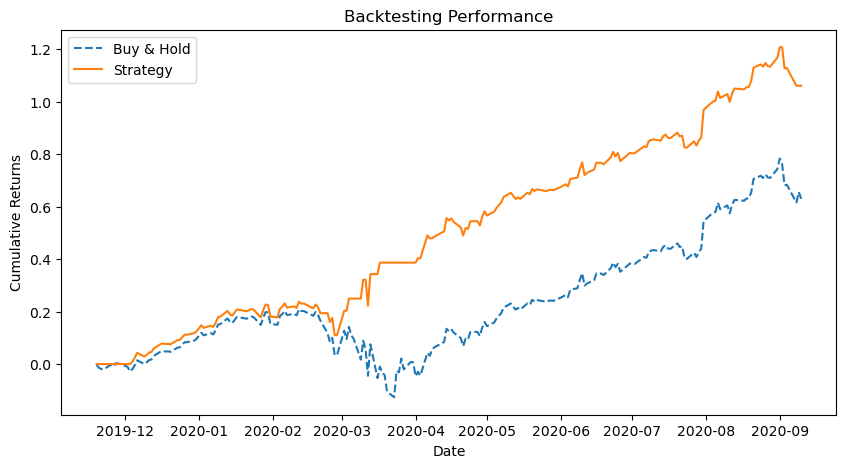

Sharpe Ratio: 0.21
Buy/Sell Signals:
                 Close   Returns Signal
Date                                   
2020-08-27  125.010002 -0.011954   Sell
2020-08-28  124.807503 -0.001620   Sell
2020-08-31  129.039993  0.033912    Buy
2020-09-01  134.179993  0.039833    Buy
2020-09-02  131.399994 -0.020718   Sell
2020-09-03  120.879997 -0.080061   Sell
2020-09-04  120.959999  0.000662    Buy
2020-09-08  112.820000 -0.067295   Sell
2020-09-09  117.320000  0.039887    Buy
2020-09-10  114.274597 -0.025958   Sell


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import ta   

# Load dataset download from kaggle and take path from local drive
def load_data(file_path):
    df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')
    df.dropna(inplace=True)
    return df

 #Technical Indicators using ta library
def feature_engineering(df):
    df['SMA_10'] = ta.trend.sma_indicator(df['Close'], window=10)
    df['SMA_50'] = ta.trend.sma_indicator(df['Close'], window=50)
    df['RSI'] = ta.momentum.rsi(df['Close'], window=14)
    df['MACD'] = ta.trend.macd(df['Close'])
    df.dropna(inplace=True)
    return df

# Creating target variable (1 if price increases next day, else 0)
def create_target(df):
    df['Target'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
    return df

# Data Preprocessing
def preprocess_data(df):
    df = feature_engineering(df)
    df = create_target(df)
    X = df[['SMA_10', 'SMA_50', 'RSI', 'MACD']]
    y = df['Target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    return X_train, X_test, y_train, y_test, df

# Model Training & Evaluation
def train_and_evaluate(X_train, X_test, y_train, y_test):
    models = {
        'Logistic Regression': LogisticRegression(),
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    }
    
    best_model = None
    best_score = 0
    
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f'{name} Accuracy: {accuracy:.4f}')
        if accuracy > best_score:
            best_score = accuracy
            best_model = model
    print("best model is :",best_model)
    
    return best_model

# Backtesting Simple Trading Strategy
def backtest(df, model):
    df['Prediction'] = model.predict(df[['SMA_10', 'SMA_50', 'RSI', 'MACD']])
    df['Returns'] = df['Close'].pct_change()
    df['Strategy Returns'] = df['Prediction'].shift(1) * df['Returns']
    
    plt.figure(figsize=(10, 5))
    plt.plot(df.index, df['Returns'].cumsum(), label='Buy & Hold', linestyle='--')
    plt.plot(df.index, df['Strategy Returns'].cumsum(), label='Strategy', linestyle='-')
    plt.legend()
    plt.title('Backtesting Performance')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.show()

    sharpe_ratio = df['Strategy Returns'].mean() / df['Strategy Returns'].std()
    print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
     # Generate buy/sell signals
    df['Signal'] = df['Returns'].apply(lambda x: 'Buy' if x > 0 else 'Sell')
    
    print("Buy/Sell Signals:")
    print(df[['Close', 'Returns', 'Signal']].tail(10))  


#    Hyperparameter Tuning
def optimize_model(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.3]
    }
    grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f'Best Parameters: {grid_search.best_params_}')
    return grid_search.best_estimator_

  

# Main Function
def trading_prediction():
    file_path = '/Users/shankusasmal/Downloads/AAPL_daily_update.csv' 
    df = load_data(file_path)
    X_train, X_test, y_train, y_test, df = preprocess_data(df)
    model = train_and_evaluate(X_train, X_test, y_train, y_test)
    best_model = optimize_model(X_train, y_train)
    backtest(df, best_model)

trading_prediction()

